<a href="https://colab.research.google.com/github/dnguyen1196/Horseshoe-VAE/blob/master/Horseshoe_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Set up

## Download KEGG file from GGdrive




In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import networkx as nx
G = nx.read_gpickle("/content/drive/My Drive/BDL_project/kegg.ungraph.pkl")

for n in G.nodes:
    print("Fingerprints for node %s: %r" % (n, G.nodes[n]["fingerprint"]))
    break
    
for e in G.edges:
    print(e)
    break

Fingerprints for node C00013: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])
('C00013', 'C00009')


## Install torch and autograd

NOTE:
Compared to the reference VAE implementation, the main difference is in the calc_vi_loss function
where the likelihood term has been augmented with the loss term to reconstruct the adjacency matrix


In [2]:
# Install the necssary packages
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install autograd

  Running setup.py bdist_wheel for autograd ... - \ done
  Stored in directory: /root/.cache/pip/wheels/72/6f/c2/40f130cca2c91f31d354bf72de282922479c09ce0b7853c4c5
Successfully built autograd


# 1. VAE with horseshoe priors

TODO:
* Implement a Neural Network using autograd (NOT pytorch) for compatibility with FactorizedHierarchicalInvGamma
* Create a class with similar interface as AE and VAE -> calc_vi_loss function

## Util functions


In [0]:
import autograd.numpy.random as npr
import autograd.numpy as ag_np
from autograd.scipy.misc import logsumexp
from autograd.scipy.special import gammaln, psi
from autograd import grad
import numpy as np
import torch.nn as nn
from autograd.scipy.special import gammaln, psi
from copy import copy


def diag_gaussian_entropy(log_std, D):
    return 0.5 * D * (1.0 + np.log(2 * np.pi)) + np.sum(log_std)


def inv_gamma_entropy(a, b):
    return np.sum(a + np.log(b) + gammaln(a) - (1 + a) * psi(a))


def log_normal_entropy(log_std, mu, D):
    return np.sum(log_std + mu + 0.5) + (D / 2) * np.log(2 * np.pi)


def make_batches(n_data, batch_size):
    return [slice(i, min(i+batch_size, n_data)) for i in range(0, n_data, batch_size)]


def bce_loss(x, x_prime):
    temp1 = x * ag_np.log(x_prime + 1e-10)
    temp2 = (1 - x) * ag_np.log(1 - x_prime + 1e-10)
    bce = -ag_np.sum(temp1 + temp2)
    return bce


def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+ag_np.exp(-x))


def adam(grad, x, callback=None, num_iters=100, step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, polyak=False):
    """Adapted from autograd.misc.optimizers"""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        if callback: callback(x, i, g, polyak)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
    return x


# Base auto-encoder

class VAE(nn.Module):
    def __init__(self):
        pass

    def encode(self, x):
        raise NotImplementedError

    def decode(self, z):
        raise NotImplementedError

    def forward(self, x):
        raise NotImplementedError

    def fit(self, X, Y):
        raise NotImplementedError

    def elbos(self):
        raise NotImplementedError

    def train_accuracy(self):
        raise NotImplementedError

    def test_accuracy(self):
        raise NotImplementedError

## Neural network and FactorizedInverseGamma inference

In [0]:
""" Uses a non-centered parameterization of the model.
    Fully factorized Gaussian + IGamma Variational distribution
	q = N(w_ijl | m_ijl, sigma^2_ijl) N(ln \tau_kl | params) IGamma(\lambda_kl| params)
	IGamma(\tau_l | params) IGamma(\lambda_l| params)
"""

import autograd.numpy.random as npr
# import autograd.numpy as ag_np
import autograd.numpy as np
from autograd.scipy.misc import logsumexp
from autograd.scipy.special import gammaln, psi
from autograd import grad
from copy import copy
# import numpy as np


"""
A neural network class built on autograd for compatibility with Hs prior current implementations
"""
class NeuralNetworkAutoGrad():
    def __init__(self, nn_structure=[32], n_dims_input=1, n_dims_output=1, \
                 weight_fill_func=np.zeros, bias_fill_func=np.zeros, activation_func=lambda x: ag_np.maximum(0, x)):

        self.nn_param_list = []
        self.activation_func = activation_func
        self.n_dims_input = n_dims_input
        self.n_dims_output = n_dims_output

        n_hiddens_per_layer_list = [n_dims_input] + nn_structure + [n_dims_output]

        # Given full network size list is [a, b, c, d, e]
        # For loop should loop over (a,b) , (b,c) , (c,d) , (d,e)
        for n_in, n_out in zip(n_hiddens_per_layer_list[:-1], n_hiddens_per_layer_list[1:]):
            self.nn_param_list.append(
                dict(
                    w=weight_fill_func((n_in, n_out)),
                    b=bias_fill_func((n_out,)),
                ))

    def forward(self, x):
        for layer_id, layer_dict in enumerate(self.nn_param_list):
            if layer_id == 0:
                if x.ndim > 1:
                    in_arr = x
                else:
                    if x.size == self.nn_param_list[0]['w'].shape[0]:
                        in_arr = x[ag_np.newaxis, :]
                    else:
                        in_arr = x[:, ag_np.newaxis]
            else:
                in_arr = self.activation_func(out_arr)
            out_arr = ag_np.dot(in_arr, layer_dict['w']) + layer_dict['b']
        return ag_np.squeeze(out_arr)


class FactorizedHierarchicalInvGamma:
    def __init__(self, n_weights, lambda_a, lambda_b, lambda_b_global, tau_a, shapes, train_stats, classification=True,
                 n_data=None):
        self.name = "Factorized Hierarchical Inverse Gamma Variational Approximation"
        self.classification = classification
        self.n_weights = n_weights
        self.shapes = shapes
        self.num_hidden_layers = len(shapes) - 1
        self.lambda_a_prior = lambda_a
        self.lambda_b_prior = lambda_b
        self.lambda_a_prior_global = 0.5
        self.lambda_b_prior_global = lambda_b_global
        self.lambda_a_prior_oplayer = 0.5
        self.lambda_b_prior_oplayer = 1.
        self.tau_a_prior = tau_a
        self.tau_a_prior_global = 0.5
        self.tau_a_prior_oplayer = 0.5
        self.l2pi = np.log(2 * np.pi)
        self.n_data = n_data
        self.noise_entropy = None

    ######### PACK UNPACK PARAMS #################################################
    def initialize_variational_params(self, param_scale=1):
        # Initialize weights
        wlist = list()
        for m, n in self.shapes:
            wlist.append(npr.randn(m * n) * np.sqrt(2 / m))
            wlist.append(np.zeros(n))  # bias
        w = np.concatenate(wlist)
        log_sigma = param_scale * npr.randn(w.shape[0]) - 10.
        # initialize scale parameters
        self.tot_outputs = 0
        for _, num_hl_outputs in self.shapes:
            self.tot_outputs += num_hl_outputs
        # No hs priors on the outputs
        self.tot_outputs = self.tot_outputs - self.shapes[-1][1]

        tau_mu, tau_log_sigma, tau_global_mu, tau_global_log_sigma, tau_oplayer_mu, tau_oplayer_log_sigma = \
            self.initialize_scale_from_prior()
        init_params = np.concatenate([w.ravel(), log_sigma.ravel(),
                                      tau_mu.ravel(), tau_log_sigma.ravel(), tau_global_mu.ravel(),
                                      tau_global_log_sigma.ravel(), tau_oplayer_mu, tau_oplayer_log_sigma])

        return init_params

    def initialize_scale_from_prior(self):
        # scale parameters (hidden + observed),
        self.lambda_a_hat = (self.tau_a_prior + self.lambda_a_prior) * np.ones([self.tot_outputs, 1]).ravel()
        self.lambda_b_hat = (1.0 / self.lambda_b_prior ** 2) * np.ones([self.tot_outputs, 1]).ravel()
        self.lambda_a_hat_global = (self.tau_a_prior_global + self.lambda_a_prior_global) \
                                   * np.ones([self.num_hidden_layers, 1]).ravel()
        self.lambda_b_hat_global = (1.0 / self.lambda_b_prior_global ** 2) * np.ones(
            [self.num_hidden_layers, 1]).ravel()
        # set oplayer lambda param
        self.lambda_a_hat_oplayer = np.array(self.tau_a_prior_oplayer + self.lambda_a_prior_oplayer).reshape(-1)
        self.lambda_b_hat_oplayer = (1.0 / self.lambda_b_prior_oplayer ** 2) * np.ones([1]).ravel()
        # sample from half cauchy and log to initialize the mean of the log normal
        sample = np.abs(self.lambda_b_prior * (npr.randn(self.tot_outputs) / npr.randn(self.tot_outputs)))
        tau_mu = np.log(sample)
        tau_log_sigma = npr.randn(self.tot_outputs) - 10.
        # one tau_global for each hidden layer
        sample = np.abs(
            self.lambda_b_prior_global * (npr.randn(self.num_hidden_layers) / npr.randn(self.num_hidden_layers)))
        tau_global_mu = np.log(sample)
        tau_global_log_sigma = npr.randn(self.num_hidden_layers) - 10.
        # one tau for all op layer weights
        sample = np.abs(self.lambda_b_hat_oplayer * (npr.randn() / npr.randn()))
        tau_oplayer_mu = np.log(sample)
        tau_oplayer_log_sigma = npr.randn(1) - 10.

        return tau_mu, tau_log_sigma, tau_global_mu, tau_global_log_sigma, tau_oplayer_mu, tau_oplayer_log_sigma

    def unpack_params(self, params):
        # unpack params
        w_vect = params[:self.n_weights]
        num_std = 2 * self.n_weights

        sigma = np.log(1 + np.exp(params[self.n_weights:num_std]))

        tau_mu = params[num_std:num_std + self.tot_outputs]
        tau_sigma = np.log(
            1 + np.exp(params[num_std + self.tot_outputs:num_std + 2 * self.tot_outputs]))
        tau_mu_global = params[num_std + 2 * self.tot_outputs: num_std + 2 * self.tot_outputs + self.num_hidden_layers]
        tau_sigma_global = np.log(1 + np.exp(params[num_std + 2 * self.tot_outputs + self.num_hidden_layers:num_std +
                                                                                                            2 * self.tot_outputs + 2 * self.num_hidden_layers]))
        tau_mu_oplayer = params[num_std + 2 * self.tot_outputs + 2 * self.num_hidden_layers: num_std +
                                                                                             2 * self.tot_outputs + 2 * self.num_hidden_layers + 1]
        tau_sigma_oplayer = np.log(
            1 + np.exp(params[num_std + 2 * self.tot_outputs + 2 * self.num_hidden_layers + 1:]))

        return w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer

    def unpack_layer_weight_variances(self, sigma_vect):
        for m, n in self.shapes:
            yield sigma_vect[:m * n].reshape((m, n)), sigma_vect[m * n:m * n + n]
            sigma_vect = sigma_vect[(m + 1) * n:]

    def unpack_layer_weight_priors(self, tau_vect):
        for m, n in self.shapes:
            yield tau_vect[:n]
            tau_vect = tau_vect[n:]

    def unpack_layer_weights(self, w_vect):
        for m, n in self.shapes:
            yield w_vect[:m * n].reshape((m, n)), w_vect[m * n:m * n + n]
            w_vect = w_vect[(m + 1) * n:]

    ######### Fixed Point Updates ################################## #####
    def fixed_point_updates(self, params):
        if self.classification:
            w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer = \
                self.unpack_params(params)
        else:
            w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer, _, _ \
                = self.unpack_params(params)
        # update lambda moments
        self.lambda_b_hat = np.exp(-tau_mu + 0.5 * tau_sigma ** 2) + (1. / self.lambda_b_prior ** 2)
        self.lambda_b_hat_global = np.exp(-tau_mu_global + 0.5 * tau_sigma_global ** 2) + (
            1. / self.lambda_b_prior_global ** 2)
        self.lambda_b_hat_oplayer = np.exp(-tau_mu_oplayer + 0.5 * tau_sigma_oplayer ** 2) + (
            1. / self.lambda_b_prior_oplayer ** 2)
        return None

    ######### ELBO CALC ################################################
    def forward(self, mu_vect, sigma_vect, tau_mu_vect, tau_sigma_vect, tau_mu_global, tau_sigma_global,
                tau_mu_oplayer, tau_sigma_oplayer, inputs):
        for layer_id, (mu, var, tau_mu, tau_sigma) in enumerate(
                zip(self.unpack_layer_weights(mu_vect), self.unpack_layer_weight_variances(sigma_vect),
                    self.unpack_layer_weight_priors(tau_mu_vect),
                    self.unpack_layer_weight_priors(tau_sigma_vect))):
            w, b = mu
            sigma__w, sigma_b = var
            if layer_id < len(self.shapes) - 1:
                scale_mu = 0.5 * (tau_mu + tau_mu_global[layer_id])
                scale_v = 0.25 * (tau_sigma ** 2 + tau_sigma_global[layer_id] ** 2)
                scale = np.exp(scale_mu + np.sqrt(scale_v) * npr.randn(tau_mu.shape[0]))
                mu_w = np.dot(inputs, w) + b
                v_w = np.dot(inputs ** 2, sigma__w ** 2) + sigma_b ** 2
                outputs = (np.sqrt(v_w) / np.sqrt(inputs.shape[1])) * np.random.normal(size=mu_w.shape) + mu_w
                outputs = scale * outputs
                inputs = outputs * (outputs > 0)
            else:
                op_scale_mu = 0.5 * tau_mu_oplayer
                op_scale_v = 0.25 * tau_sigma_oplayer ** 2
                Ekappa_half = np.exp(op_scale_mu + np.sqrt(op_scale_v) * npr.randn())
                mu_w = np.dot(inputs, w) + b
                v_w = np.dot(inputs ** 2, sigma__w ** 2) + sigma_b ** 2
                outputs = Ekappa_half * (np.sqrt(v_w) / np.sqrt(inputs.shape[1])) * np.random.normal(
                    size=mu_w.shape) + mu_w
        return outputs

    def EPw_Gaussian(self, prior_precision, w, sigma):
        """"\int q(z) log p(z) dz, assuming gaussian q(z) and p(z)"""
        wD = w.shape[0]
        prior_wvar_ = 1. / prior_precision
        a = - 0.5 * wD * np.log(2 * np.pi) - 0.5 * wD * np.log(prior_wvar_) - 0.5 * prior_precision * (
            np.dot(w.T, w) + np.sum((sigma ** 2)))
        return a

    def EP_Gamma(self, Egamma, Elog_gamma):
        """ Enoise precision """
        return self.noise_a * np.log(self.noise_b) - gammaln(self.noise_a) + (
                                                                                 - self.noise_a - 1) * Elog_gamma - self.noise_b * Egamma

    def EPtaulambda(self, tau_mu, tau_sigma, tau_a_prior, lambda_a_prior,
                    lambda_b_prior, lambda_a_hat, lambda_b_hat):
        """ E[ln p(\tau | \lambda)] + E[ln p(\lambda)]"""
        etau_given_lambda = -gammaln(tau_a_prior) - tau_a_prior * (np.log(lambda_b_hat) - psi(lambda_a_hat)) + (
                                                                                                                   -tau_a_prior - 1.) * tau_mu - np.exp(
            -tau_mu + 0.5 * tau_sigma ** 2) * (lambda_a_hat /
                                               lambda_b_hat)
        elambda = -gammaln(lambda_a_prior) - 2 * lambda_a_prior * np.log(lambda_b_prior) + (-lambda_a_prior - 1.) * (
            np.log(lambda_b_hat) - psi(lambda_a_hat)) - (1. / lambda_b_prior ** 2) * (lambda_a_hat / lambda_b_hat)
        return np.sum(etau_given_lambda) + np.sum(elambda)

    def entropy(self, sigma, tau_sigma, tau_mu, tau_sigma_global, tau_mu_global, tau_sigma_oplayer, tau_mu_oplayer):
        ent_w = diag_gaussian_entropy(np.log(sigma), self.n_weights)
        ent_tau = log_normal_entropy(np.log(tau_sigma), tau_mu, self.tot_outputs) + log_normal_entropy(
            np.log(tau_sigma_global), tau_mu_global, self.num_hidden_layers) + log_normal_entropy(
            np.log(tau_sigma_oplayer), tau_mu_oplayer, 1)
        ent_lambda = inv_gamma_entropy(self.lambda_a_hat, self.lambda_b_hat) + inv_gamma_entropy(
            self.lambda_a_hat_global, self.lambda_b_hat_global) + inv_gamma_entropy(self.lambda_a_hat_oplayer,
                                                                                    self.lambda_b_hat_oplayer)
        return ent_w, ent_tau, ent_lambda







## HS_VAE implementations

In [0]:



class HS_VAE(VAE):
    def __init__(
            self,
            q_sigma=0.2,
            n_dims_code=16,
            n_dims_data=64,
            hidden_layer_sizes=[32],
            classification=True,
            batch_size=128,
            lambda_b_global=1.0,
            warm_up=False,
            polyak=False, ):

        super(HS_VAE, self).__init__()
        layer_sizes = (
            [n_dims_data] + hidden_layer_sizes + [n_dims_code]
        )
        self.n_dims_code = n_dims_code
        self.q_sigma = q_sigma
        self.n_dims_data = n_dims_data

        self.shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
        self.layer_sizes = layer_sizes
        self.lambda_b_global = lambda_b_global
        self.N_weights = sum((m + 1) * n for m, n in self.shapes)

        self.elbo = list()
        self.val_ll = list()
        self.val_err = list()
        self.train_err = list()
        self.test_err = list()

        self.variational_params = None
        self.init_params = None
        self.polyak_params = None
        self.polyak = polyak
        self.variational_params_store = {}
        self.optimal_elbo_params = None
        self.warm_up = warm_up  # if True, anneal in KL

        # TODO: in Ghosh's implementation, mu is the mean of all x_train and
        # TODO: sigma is the standard deviation of all x_train
        train_stats = dict()
        train_stats['mu'] = 0
        train_stats['sigma'] = 1

        # Initialize the encoder and decoder
        # TODO: incorporate Factorized Hierarchical Inverse Gamma
        self.horseshoe_encoder = FactorizedHierarchicalInvGamma(
            lambda_a=0.5, lambda_b=1.0,
            lambda_b_global=self.lambda_b_global, tau_a=0.5,
            shapes=self.shapes, train_stats=train_stats,
            classification=classification,
            n_weights=self.N_weights)

        self.decoder = NeuralNetworkAutoGrad(nn_structure=hidden_layer_sizes, \
                                             n_dims_input=n_dims_code, n_dims_output=n_dims_data)

    def neg_elbo(self, params, epoch, xs_ND, ys_ND, matrix_entries):
        """

        :param params:
        :param epoch:
        :param xs_ND:
        :param ys_ND:
        :param matrix_entries:
        :return:
        """
        if self.warm_up:
            nt = 200  # linear increments between 0 and 1 up to nt (1 after nt)
            temperature = epoch / nt
            if temperature > 1:
                temperature = 1
        else:
            temperature = 1

        # Unpack the current parameters using function provided by Inv-Gamma
        w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer \
            = self.horseshoe_encoder.unpack_params(params)

        # Compute the x_NC codes and y_NC codes (latent embeddings)
        xs_NC = self.horseshoe_encoder.forward(w_vect, sigma, tau_mu, tau_sigma, \
                                               tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer,
                                               xs_ND)

        ys_NC = self.horseshoe_encoder.forward(w_vect, sigma, tau_mu, tau_sigma, \
                                               tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer,
                                               ys_ND)

        # Compute log likelihood
        # TODO: check if there is any scaling factor I need to compute based on implementions in InvGamma
        log_lik = self.log_likelihood_compute(xs_NC, ys_NC, xs_ND, ys_ND, matrix_entries)

        # Compute the entropies and log_prior
        # Note that this is taken from implementations from inv-Gamma
        log_prior, ent_w, ent_tau, ent_lambda = self.entropy_compute(params)

        log_variational = ent_w + ent_tau + ent_lambda
        minibatch_rescaling = 1. / self.M
        ELBO = temperature * minibatch_rescaling * (log_variational + log_prior) + log_lik
        return -1 * ELBO

    def entropy_compute(self, params):
        w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer \
            = self.horseshoe_encoder.unpack_params(params)

        log_prior = self.horseshoe_encoder.EPw_Gaussian(1., w_vect, sigma)
        log_prior = log_prior + \
                    self.horseshoe_encoder.EPtaulambda(tau_mu, tau_sigma, self.horseshoe_encoder.tau_a_prior, \
                                                       self.horseshoe_encoder.lambda_a_prior,
                                                       self.horseshoe_encoder.lambda_b_prior,
                                                       self.horseshoe_encoder.lambda_a_hat,
                                                       self.horseshoe_encoder.lambda_b_hat) + \
                    self.horseshoe_encoder.EPtaulambda(tau_mu_global, tau_sigma_global,
                                                       self.horseshoe_encoder.tau_a_prior_global,
                                                       self.horseshoe_encoder.lambda_a_prior_global,
                                                       self.horseshoe_encoder.lambda_b_prior_global,
                                                       self.horseshoe_encoder.lambda_a_hat_global,
                                                       self.horseshoe_encoder.lambda_b_hat_global) + \
                    self.horseshoe_encoder.EPtaulambda(tau_mu_oplayer, tau_sigma_oplayer,
                                                       self.horseshoe_encoder.tau_a_prior_oplayer,
                                                       self.horseshoe_encoder.lambda_a_prior_oplayer,
                                                       self.horseshoe_encoder.lambda_b_prior_oplayer,
                                                       self.horseshoe_encoder.lambda_a_hat_oplayer,
                                                       self.horseshoe_encoder.lambda_b_hat_oplayer)

        # Compute the entropies
        ent_w, ent_tau, ent_lambda = self.horseshoe_encoder.entropy(sigma, tau_sigma, tau_mu, tau_sigma_global,
                                                                    tau_mu_global,
                                                                    tau_sigma_oplayer, tau_mu_oplayer)

        return log_prior, ent_w, ent_tau, ent_lambda

    def log_likelihood_compute(self, xs_NC, ys_NC, xs_ND, ys_ND, matrix_entries):
        """
        :param xs_NC:
        :param ys_NC:
        :param xs_ND:
        :param ys_ND:
        :param matrix_entries:
        :return:
        """
        n_mc_samples = 20
        log_lik = 0.

        # Generate samples from N(mx_NC, q_sigma) to compute the following
        # E_q[log p(x_ND|mx_NC)]
        for ss in range(n_mc_samples):
            sample_xz_NC = self.draw_sample_from_q(xs_NC)
            sample_xproba_ND = self.decode(sample_xz_NC)

            sample_yz_NC = self.draw_sample_from_q(ys_NC)
            sample_yproba_ND = self.decode(sample_yz_NC)

            # Use MSE to measure reconstruction loss
            # Since MSE is equivalent to log gaussian loss
            log_ll_x_reconstructed = -0.5 * ag_np.sum((sample_xproba_ND - xs_ND) ** 2)
            log_ll_y_reconstructed = -0.5 * ag_np.sum((sample_yproba_ND - ys_ND) ** 2)

            # KL divergence from q(mu, sigma) to prior (std normal)
            log_lik += 1 / n_mc_samples * (log_ll_x_reconstructed + log_ll_y_reconstructed)

        # Compute the loss from adjacency matrix reconstruction
        # Get number of entries
        num_samples = len(matrix_entries)
        f_predict = ag_np.zeros(num_samples)

        # Compute
        # E_q[log p(A_ij|x_i, x_j)] = E_q[Bern(A_ij|sigmoid(x_i dot x_j))]
        for ss in range(n_mc_samples):
            # These two should have the same shape
            # which is (N*C)
            sample_xz_NC = self.draw_sample_from_q(xs_NC)
            sample_yz_NC = self.draw_sample_from_q(ys_NC)

            # inner_prod.shape = (N,)
            inner_prod = ag_np.sum(sample_xz_NC * sample_yz_NC, axis=1)
            f_predict += 1 / n_mc_samples * sigmoid(inner_prod)

        matrix_reconstruction_loss = bce_loss(matrix_entries, f_predict)
        log_lik_matrix_reconstruction = -matrix_reconstruction_loss
        log_lik += log_lik_matrix_reconstruction
        return log_lik

    def decode(self, z):
        return self.decoder.forward(z)

    def draw_sample_from_q(self, xs_NC):
        N = xs_NC.shape[0]
        # The dimension of the code
        C = self.n_dims_code
        # Draw standard normal samples "epsilon"
        # Use the reparameterization trick
        eps_NC = np.random.randn(N, C)
        z_NC = xs_NC + eps_NC * self.q_sigma
        return z_NC

    def calc_vi_loss(self, params, t):
        idx = t % self.M
        # TODO: do mini-batch computation here
        x_ND = self.feature_vectors[idx]
        observed_entries = self.train_adjacency_matrix[idx]
        other_vec_idx = [entry[0][1] for entry in observed_entries]
        matrix_entries = [entry[1] for entry in observed_entries]

        # print("{} {}".format(len(observed_entries), len(matrix_entries)))

        xs_ND = []
        ys_ND = []
        for idy in other_vec_idx:
            xs_ND.append(copy(x_ND))
            ys_ND.append(copy(self.feature_vectors[idy, :]))

        negative_idx = np.random.choice(self.M, self.num_negatives, replace=False)
        for idy in negative_idx:
            xs_ND.append(copy(x_ND))
            ys_ND.append(copy(self.feature_vectors[idy, :]))
            matrix_entries.append(0)


        xs_ND = ag_np.asarray(xs_ND)
        ys_ND = ag_np.asarray(ys_ND)
        matrix_entries = ag_np.asarray(matrix_entries)

        return self.neg_elbo(params, t / self.M, xs_ND, ys_ND, matrix_entries)

    def fit(self, feature_vectors, train_adjacency_matrix, n_epochs=10, l_rate=0.01, test_adjacency_matrix=None, num_negatives=64):
        self.M = feature_vectors.shape[0]
        # TODO: Number of nodes is the number of minibatches in an epoch?
        self.feature_vectors = feature_vectors
        self.train_adjacency_matrix = train_adjacency_matrix
        self.num_negatives = num_negatives

        # TODO: look into how to do mini-batches
        self.test_adjacency_matrix = test_adjacency_matrix

        def callback(params, t, g, decay=0.999):
            # if t % 100 == 0:
            #     print(t)
            if self.polyak:
                # exponential moving average.
                self.polyak_params = decay * self.polyak_params + (1 - decay) * params

            # If empty row in the adjacency matrix, skip this update
            idx = t % self.M
            elbo = -self.calc_vi_loss(params, t)

            self.elbo.append(elbo)

            if (int(t) % self.M) == 0:
                train_err = self.compute_accuracy(params, test=False)
                test_err = self.compute_accuracy(params, test=True)
                self.train_err.append(train_err)
                self.test_err.append(test_err)

                print("Epoch {} elbo {} train-accuracy {} test-accuracy {}".format(t / self.M, self.elbo[-1],
                                                                                       self.train_err[-1],
                                                                                       self.test_err[-1]))

            # if (t % 250) == 0:
            #     # store optimization progress.
            #     self.variational_params_store[t] = copy(params)

            if t > 2:
                if self.elbo[-1] > max(self.elbo[:-1]):
                    self.optimal_elbo_params = copy(params)

            # update inverse gamma distributions
            self.horseshoe_encoder.fixed_point_updates(params)

        # Variational parameters include tau, lambda, v, Vu etc
        init_var_params = self.horseshoe_encoder.initialize_variational_params()
        self.init_params = copy(init_var_params)

        if self.polyak:
            self.polyak_params = copy(init_var_params)

        gradient = grad(self.calc_vi_loss, 0)
        num_iters = n_epochs * self.M  # one iteration = one set of param updates

        # Run the algorithm using Adam with callback
        self.variational_params = adam(gradient, init_var_params,
                                       step_size=l_rate, num_iters=num_iters, callback=callback,
                                       polyak=self.polyak)

    def compute_accuracy(self, params, test=True):
        W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer = \
            self.horseshoe_encoder.unpack_params(params)

        z_NC = self.horseshoe_encoder.forward(W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global,
                                              tau_mu_oplayer, tau_sigma_oplayer, self.feature_vectors)

        # z_NC has shape (N,C)
        num_accurate = 0.0
        num_observed = 0.0

        latent_adj_mat = np.dot(z_NC, z_NC.T)

        if test:
            adjancency_matrix = self.test_adjacency_matrix
        else:
            adjancency_matrix = self.train_adjacency_matrix

        for row in adjancency_matrix:
            for coor, val in row:
                if (latent_adj_mat[coor[0]][coor[1]] < 0.0 and val == 0.0 or
                                latent_adj_mat[coor[0]][coor[1]] >= 0.0 and val == 1.0):
                    num_accurate += 1
                num_observed += 1

        return num_accurate / num_observed

# 2. Standard VAE class
TODO
* (Not important) AutoEncoder implementation (not Variational) for comparisons

In [0]:
from __future__ import print_function


import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable

epsilon = 0.00001


class NeuralNetwork(nn.Module):
    def __init__(
            self,
            n_dims_code=16,
            n_dims_data=32,
            hidden_layer_sizes=[32],
            encoder=True,
    ):
        
        """
        q_sigma = 0.2
        """
        super(NeuralNetwork, self).__init__()

        self.n_dims_data = n_dims_data
        self.n_dims_code = n_dims_code
        layer_sizes = (
            [n_dims_data] + hidden_layer_sizes + [n_dims_code]
        )
        self.n_layers = len(layer_sizes) - 1

        if not encoder:
            layer_sizes = [a for a in reversed(layer_sizes)]

        self.activations = list()
        self.params = nn.ModuleList()
        for (n_in, n_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.params.append(nn.Linear(n_in, n_out))
            self.activations.append(F.relu)
        self.activations[-1] = lambda a: a
            
    def forward(self, x):
        # Note that if x contains multiple instance
        # if x.shape = (num_sample, in_dim)
        # then the output shape will be (num_sample, out_dim)
        cur_arr = x
        for ll in range(self.n_layers):
            linear_func = self.params[ll]
            a_func = self.activations[ll]
            cur_arr = a_func(linear_func(cur_arr))
        mu_NC = cur_arr
        return mu_NC
      
    def regularize(self):
        reg_loss = 0.0
        for param in self.params:
            mats = torch.cat([x.view(-1) for x in param.parameters()])
            reg_loss += torch.norm(mats, 1)

        return reg_loss
      
      
class VariationalAutoencoder(nn.Module):
    def __init__(
            self,
            q_sigma=0.2,
            n_dims_code=16,
            n_dims_data=64,
            hidden_layer_sizes=[32],
            reg_lambda=0.0,
    ):

        super(VariationalAutoencoder, self).__init__()
        self.n_dims_data = n_dims_data
        self.n_dims_code = n_dims_code
        self.q_sigma = torch.Tensor([float(q_sigma)])
        self.lam = reg_lambda
        
        # Encoder network
        self.encoder = NeuralNetwork(
            n_dims_code=n_dims_code,
            n_dims_data=n_dims_data,
            hidden_layer_sizes=hidden_layer_sizes,
            encoder=True,
        )
        # Decoder network
        self.decoder = NeuralNetwork(
            n_dims_code=n_dims_code,
            n_dims_data=n_dims_data,
            hidden_layer_sizes=hidden_layer_sizes,
            encoder=False,
        )
        self.train_losses = []
        self.test_losses = []
        self.ELBOs = []
        self.epochs = []
        self.all_epochs = []
        
        
    def elbo_epochs(self):
        return self.all_epochs
      
    def loss_epochs(self):
        return self.epochs
        
    def elbos(self):
        return self.ELBOs
        
    def tr_losses(self):
        return self.train_losses 
        
    def te_losses(self):
        return self.test_losses

    def forward(self, x_ND):
        """
        Run entire probabilistic autoencoder on input (encode then decode)

        Returns
        -------
        xproba_ND : 1D array, size of x_ND
        """
        mu_NC = self.encode(x_ND)
        z_NC = self.draw_sample_from_q(mu_NC)
        return self.decode(z_NC), mu_NC

    
    def draw_sample_from_q(self, mu_NC):
        ''' Draw sample from the probabilistic encoder q(z|mu(x), \sigma)

        We assume that "q" is Normal with:
        * mean mu (argument of this function)
        * stddev q_sigma (attribute of this class, use self.q_sigma)

        Args
        ----
        mu_NC : tensor-like, N x C
            Mean of the encoding for each of the N images in minibatch.

        Returns
        -------
        z_NC : tensor-like, N x C
            Exactly one sample vector for each of the N images in minibatch.
        '''
        # Number of samples
        N = mu_NC.shape[0]
        
        # The dimension of the code
        C = self.n_dims_code

        if self.training:
            # Draw standard normal samples "epsilon"
            # Use the reparameterization trick
            eps_NC = torch.randn(N, C)
            z_NC = mu_NC + eps_NC * self.q_sigma
            return z_NC
        else:
            # For evaluations, we always just use the mean
            return mu_NC

    def encode(self, x_ND):
        """
        Args
        ----
        x_ND: the observation vector
        """
        return self.encoder.forward(x_ND)

    def decode(self, z_NC):
        """
        Args
        ----
        z_NC: the code vector
        """
        return self.decoder.forward(z_NC)

    def binary_predict_error_rate(self, f_predict, f_true):
        """
        
        """
        length = f_predict.size()[0]
        f_predict_binary = (f_predict > 0.5).type(torch.FloatTensor)
        error = torch.sum((f_predict_binary - f_true).abs_()) / length
        return error

    def calc_vi_loss(self, xs_ND, ys_ND, vals, n_mc_samples=1):
        """
        Args

        xs_ND: the input feature vectors
        ys_ND: the other feature vectors in mini-batch
        vals: the entry associated with (x,y)
        n_mc_samples: 

        ----
        Returns:
        loss

        """
        neg_expected_ll = 0.0
        # Given a (potentially) a tensor of observation vectors, 
        # Encode it into latent space
        mx_NC = self.encode(xs_ND)
        my_NC = self.encode(ys_ND)
        
        # Compute the KL divergence
        # KL(N(mx_NC, q_sigma) || N(0, I))
        kl_xz_NC = -0.5 * torch.sum(1 + torch.log(self.q_sigma ** 2) - mx_NC ** 2 - self.q_sigma ** 2)
        kl_yz_NC = -0.5 * torch.sum(1 + torch.log(self.q_sigma ** 2) - my_NC ** 2 - self.q_sigma ** 2)
        kl       = kl_xz_NC + kl_yz_NC # Total KL term
        
        # Generate samples from N(mx_NC, q_sigma) to compute the following
        # E_q[log p(x_ND|mx_NC)]
        for ss in range(n_mc_samples):
            sample_z_NC      = self.draw_sample_from_q(mx_NC)
            sample_xproba_ND = self.decode(sample_z_NC)

            # Use MSE to measure reconstruction loss
            # Since MSE is equivalent to log gaussian loss
            sample_mse_loss  = F.mse_loss(sample_xproba_ND, xs_ND)

            # KL divergence from q(mu, sigma) to prior (std normal)
            # Have to multiply (1 - epsilon) to make sure all entries are < 1
            neg_expected_ll += 1/n_mc_samples * sample_mse_loss
        
        
        # Compute the loss from adjacency matrix reconstruction
        # Get number of entries
        num_samples = len(vals)
        f_predict   = torch.zeros(num_samples)

        # Compute
        # E_q[log p(A_ij|x_i, x_j)] = E_q[Bern(A_ij|sigmoid(x_i dot x_j))]
        
        for ss in range(n_mc_samples):
            # These two should have the same shape
            # which is (N*C)
            sample_z_NC = self.draw_sample_from_q(mx_NC)
            sample_y_NC = self.draw_sample_from_q(my_NC)

            # inner_prod.shape = (N,)
            inner_prod  = torch.sum(sample_z_NC * sample_y_NC, dim=1)
            f_predict  += 1/n_mc_samples * torch.sigmoid(inner_prod) * (1 - epsilon)


        # Use binary cross entry loss, NOTE that this is for
        # adjacency matrix whose entry values are 0 and 1
        # This will need to change for other types of adjacency matrix value
        # Use the binary prediction loss with logits
        matrix_reconstruction_loss = \
            F.binary_cross_entropy(f_predict, Variable(torch.FloatTensor(vals)), reduction='sum')
        
        neg_expected_ll += matrix_reconstruction_loss
        
        # L1 regularizer term
        reg_loss = self.lam * (self.encoder.regularize() + self.decoder.regularize())
        
        return neg_expected_ll, kl, reg_loss, matrix_reconstruction_loss, sample_xproba_ND
      
    def fit(self, feature_vectors, train_adjacency_matrix, n_epochs=10, test_adjacency_matrix=None):
        # Initialize optimizer
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        for epoch in range(n_epochs): 
            # Do round-robin optimization
            for idx in range(num_nodes):
                x_ND = Variable(torch.FloatTensor([feature_vectors[idx, :]]))
                ys_ND = list()
                observed_entries = train_adjacency_matrix[idx]
                other_vec_idx = [entry[0][1] for entry in observed_entries]
                vals = [entry[1] for entry in observed_entries]

                for idy in other_vec_idx:
                    ys_ND.append(feature_vectors[idy, :])

                ys_ND = Variable(torch.FloatTensor(ys_ND))
                optimizer.zero_grad()

                # NOTE:
                # expected_ll refers to the expected log likelihood term of ELBO
                # kl refers to the KL divergence term of the ELBO
                # matrix_loss refers to the matrix reconstruction loss
                neg_expected_ll, KL, reg, matrix_loss, _ = self.calc_vi_loss(x_ND, ys_ND, vals, n_mc_samples=10)

                KL = 1/len(observed_entries) * KL
                # TODO: scale the KL term
                # ELBO loss = negative expected log likelihood + KL
                elbo_loss = neg_expected_ll + KL + reg

                elbo_loss.backward()
                optimizer.step()

            if epoch % 10 == 0:
                all_vectors = Variable(torch.FloatTensor(feature_vectors))
                train_accuracy = classification_accuracy(self, all_vectors, train_adjacency_matrix)
                test_accuracy = classification_accuracy(self, all_vectors, test_adjacency_matrix)
                self.epochs.append(epoch)
                self.all_epochs.append(epoch)
                self.ELBOs.append(-elbo_loss)
                self.train_losses.append(1.0 - train_accuracy)
                self.test_losses.append(1.0 - test_accuracy)


#             if epoch in [0, 1, 25] or epoch % 50 == 0:
#                 all_vectors = Variable(torch.FloatTensor(feature_vectors))
#                 train_accuracy = classification_accuracy(self, all_vectors, train_adjacency_matrix)
#                 test_accuracy = classification_accuracy(self, all_vectors, test_adjacency_matrix)
#                 self.epochs.append(epoch)
#                 self.train_losses.append(1.0 - train_accuracy)
#                 self.test_losses.append(1.0 - test_accuracy)

                print("epoch: ", epoch, " - objective loss: ", np.around(elbo_loss.data.item(),4), " - train accuracy: ",
                      np.around(train_accuracy,4), " - test accuracy: ", np.around(test_accuracy, 4))


# 3. Data processing


Synthetic data (and real life data to test on) should include
* Adjancency matrix (which might be sparse) where A_{ij} = 1 if there is an edge and 0 otherwise between two nodes i and j
* The feature vectors for all the nodes

TODO:
- Clean KEGG data to put int the correct format


## Synthetic data 

In [0]:
import numpy as np


def compute_entry_values(coordinates, latent_vectors):
    """
    coordinates: list of coordinates
    
    """
    vals    = list()
    for i, j in coordinates:
        if np.sum(latent_vectors[i] * latent_vectors[j]) > 0:
            vals.append(1)
        else:
            vals.append(0)
    return vals
    

def create_sparse_matrix_list(observed_coordinates, num_nodes, latent_vectors):
    """
    observed_coordinates: list of (row,col) coordinates
    num_nodes : int, number of nodes
    latent_vectors : latent vectos whose inner products used to determine adjacency
    matrix
    
    ---
    return the sparse representation of the adjacency matrix
    
    """
    sparse_adjacency_matrix = [[] for _ in range(num_nodes)]

    for entry in observed_coordinates:
        idx, idy = entry[0], entry[1]
        inner = np.dot(latent_vectors[idx, :], latent_vectors[idy, :])
        val = 0
        if inner > 0:
            val = 1

        sparse_adjacency_matrix[idx].append((entry, val))
        sparse_adjacency_matrix[idy].append(([idy, idx], val))

    return sparse_adjacency_matrix


def create_observed_features(latent_vectors, num_nodes, true_dim, observed_dim, noise_feature_num=0):
    """    
    latent_vectors : shape(num_nodes, true_dim), the latent feature vectors of all nodes
    num_nodes : int, number of nodes in this network
    true_dim  : int, dimension of the latent feature (the code)
    observed_dim : int, dimension of the observed feature vector
    num_noisy_dim : int, added noisy dimension
    
    ---
    
    Create observed features that contain both true and noisy features

    1. Create a random transformation matrix A
    2. Apply the transformation A X_l where X_l is the latent feature vectors
    3. 
    ---
    returns
    
    augmented_feature_matrix : shape(num_nodes, observed_dim + num_noisy_dim)
    the augmented observed feature vector for all the nodes, with relevent
    dimensions together with noisy entries.
    
    """

    # Create a random transformation, A
    transformation_matrix = np.random.randn(observed_dim, true_dim)

    # X_true = dot(A, x_true)
    transformed_feature = np.dot(transformation_matrix, latent_vectors.T)
    transformed_feature = transformed_feature.T
    transformed_feature /= transformed_feature.max()  # Scale the feature vectors by dividing by the max value

    # If no noisy feature, just return the transformed feature
    if noise_feature_num == 0:
        return transformed_feature
    
    # If there are noisy features, generate these from standard normal distribution
    # Noise feature = N(0, I)
    # Create noise matrix X_noise
    noise_feature_matrix = np.random.randn(num_nodes, noise_feature_num)
    augmented_dim = observed_dim + noise_feature_num

    # Horizontally concatenate X_true :: X_noise
    augmented_feature_matrix = np.hstack((transformed_feature, noise_feature_matrix))

    # Permute the features column
    augmented_feature_matrix = augmented_feature_matrix[:, np.random.permutation(augmented_dim)]
    return augmented_feature_matrix


def create_synthetic_data(num_nodes, sparsity, true_dim, observed_dim, num_noisy_dim):
    """
    num_nodes : int, number of nodes in this network
    sparsity  : float, ratio of all entries, which are observed
    true_dim  : int, dimension of the latent feature (the code)
    observed_dim : int, dimension of the observed feature vector
    num_noisy_dim : int, added noisy dimension
    
    --- 
    returns
    
    (latent_vectors, observed_feature_vectors, sparse_adjancency_matrix)
    
    latent_vectors : shape(num_nodes, true_dim), all the latent feature vectors
    observed_feature_vectors : shape(num_nodes, observed_dim), all the observed feature vectors
    sparse_adjancency_matrix : list[list(entry, value)] 
    
    """
    # Create num_nodes hidden vector randomly
    latent_vectors = np.random.multivariate_normal(np.zeros((true_dim,)), \
                                                   np.eye(true_dim), \
                                                   size=(num_nodes,))

    coordinates = [[x,y] for x in range(num_nodes) for y in range(x+1, num_nodes)]
    total_num_pairs = len(coordinates)
    num_observed = int(len(coordinates) * sparsity)

    # Pick a number of random coordinates
    observed_idx = np.random.choice(total_num_pairs, num_observed, replace=False)
    observed_coordinates = np.take(coordinates, observed_idx, axis=0)
    
    train_size = int(len(observed_coordinates) * 0.8)
    train_coordinates = observed_coordinates[:train_size]
    test_coordinates = observed_coordinates[train_size+1:]
    
    # Create sparse matrix representation
    train_sparse_adjacency_matrix = create_sparse_matrix_list(train_coordinates, num_nodes, latent_vectors)
    test_sparse_adjacency_matrix = create_sparse_matrix_list(test_coordinates, num_nodes, latent_vectors)
    
    # Create test matrix and train matrix
    observed_feature_vectors = create_observed_features(latent_vectors, num_nodes, true_dim, observed_dim,
                                                        num_noisy_dim)

    return latent_vectors, observed_feature_vectors, train_sparse_adjacency_matrix, test_sparse_adjacency_matrix

## KEGG data preprocessing

TODO:
* Get the list of nodes from G.nodes
* Get the list of edges from G.edges
and then figure out how to do "negative" sampling, namely the absence of edges
* Later, do "negative sampling" during training


In [0]:
import networkx as nx
import numpy as np
import random

random.seed(42)
G = nx.read_gpickle("/content/drive/My Drive/BDL_project/kegg.ungraph.pkl")

node_to_ind = {}
ind_to_node = {}
ind = 0
all_chem = []
feature_vectors_kegg = []
adjacency_matrix_kegg = []
unique_links_list = []
adjacency_list_kegg = {}
non_edges = set()
num_edges = 0
neg_ratio = 1.0

# Create feature vectors
for n in G.nodes:
    all_chem.append(n)
    node_to_ind[n] = ind
    ind_to_node[ind] = n
    ind += 1
    feature_vectors_kegg.append(G.nodes[n]["fingerprint"].astype(float))
    
feature_vectors_kegg = np.vstack(feature_vectors_kegg)    

# Record positive edges into adjacency set
for e in G.edges:
    num_edges += 1
    if e[0] not in adjacency_list_kegg:
        adjacency_list_kegg[e[0]] = set()
    if e[1] not in adjacency_list_kegg:
        adjacency_list_kegg[e[1]] = set()
    adjacency_list_kegg[e[0]].add(e[1])    
    adjacency_list_kegg[e[1]].add(e[0])
    unique_links_list.append(([node_to_ind[e[0]], node_to_ind[e[1]]], 1))
    
# Randomly sample non-edges with neg_ratio * amount as edges
num_sampled = 0
while num_sampled < neg_ratio * num_edges:
    v1 = random.randint(0, len(all_chem) - 1)
    v2 = random.randint(0, len(all_chem) - 1)
    n1 = ind_to_node[v1]
    n2 = ind_to_node[v2]
    
    if (
        (n1, n2) not in non_edges and
        (n2, n1) not in non_edges and
        n2 not in adjacency_list_kegg[n1]
    ):
        non_edges.add((n1, n2))
        unique_links_list.append(([v1, v2], 0))
  
    num_sampled += 1

# Record edges and non-edges into sparse adjacency matrix
# for c1 in adjacency_list_kegg:
#     for c2 in adjacency_list_kegg[c1]:
#         adjacency_matrix_kegg.append(([node_to_ind[c1], node_to_ind[c2]], 1))
        
# for ne in non_edges:
#     # Make sure matrix is symmetric
#     if n[0] != n[1]:
#         adjacency_matrix_kegg.append(([node_to_ind[ne[0]], node_to_ind[ne[1]]], 0))
#         adjacency_matrix_kegg.append(([node_to_ind[ne[1]], node_to_ind[ne[0]]], 0))
#     else:
#         adjacency_matrix_kegg.append(([node_to_ind[ne[0]], node_to_ind[ne[1]]], 0))

# adjacency_matrix_kegg.sort(key=lambda tup: tup[0])
# print(adjacency_matrix_kegg)
# num0 = 0
# num1 = 1
# for e in adjacency_matrix_kegg:
#     if e[1] == 1:
#         num1 += 1
#     else:
#         num0 += 1
# print(num0)
# print(num1)


def create_train_test_adj_matrices(unique_links, num_nodes, ratio=0.8):
    num_train_links = int(ratio*len(unique_links))
    train_inds = random.sample(range(0, len(unique_links)), num_train_links)
    test_inds = list(set(range(0, len(unique_links))) - set(train_inds))
    train_links = [unique_links[i] for i in train_inds]
    test_links = [unique_links[i] for i in test_inds]
    
    train_sparse_matrix = [[] for _ in range(num_nodes)]
    test_sparse_matrix = [[] for _ in range(num_nodes)]
    
    for ([id1, id2], val) in test_links:
        test_sparse_matrix[id1].append(([id1, id2], val))
        if id1 != id2:
            test_sparse_matrix[id2].append(([id2, id1], val))
        
    for ([id1, id2], val) in train_links:
        train_sparse_matrix[id1].append(([id1, id2], val))
        if id1 != id2:
            train_sparse_matrix[id2].append(([id2, id1], val))
            
    return train_sparse_matrix, test_sparse_matrix
  
train_adjacency_matrix_kegg, test_adjacency_matrix_kegg = create_train_test_adj_matrices(unique_links_list, len(all_chem), ratio=0.8)

#4. Do VAE training

TODO:
* Update the training function, first generate synthetic data, organize into batches
* Extension: Compare between round-robin updates (aka update each row by row where the list of observations always share a common row index) vs mini-batch update where the list of observations can contain any random pair of two indices.


## 4.1 Evaluation utility function

In [0]:
# Function to do evaluation

from torch import nn, optim
from torch.autograd import Variable
import torch
import numpy as np
from matplotlib import pyplot as plt


def classification_accuracy(model, feature_tensor, adjacency_matrix, report=False):
    """
    Feature vectors.shape -> (num_nodes, number of observed features)
    adjancency_matrix -> sparse representation of adjancey matrix
    where each row -> list of (coordinates, value) associated with the specific
    factor

    Uses model.encode(feature_vector)
    """
    latent_vectors = model.encode(feature_tensor)
    latent_adj_mat = torch.mm(latent_vectors, latent_vectors.transpose(0 , 1))
    num_accurate = 0.0
    num_observed = 0.0
    for row in adjacency_matrix:
        for coor, val in row:
            if (
                latent_adj_mat[coor[0]][coor[1]].item() < 0.0 and val == 0.0 or
                latent_adj_mat[coor[0]][coor[1]].item() >= 0.0 and val == 1.0
            ):

                if report:
                    print("predict: ", latent_adj_mat[coor[0]][coor[1]].item(), " val: ", val)

                num_accurate += 1
            num_observed += 1

    return num_accurate/ num_observed


def classification_error_rate(model, feature_tensor, adjacency_matrix, report=False):
    return 1  -classification_accuracy(model, feature_tensor, adjacency_matrix, report)


## 4.2 Training on synthetic data

epoch:  0  - objective loss:  20.502  - train accuracy:  0.5956  - test accuracy:  0.5547
epoch:  10  - objective loss:  20.8639  - train accuracy:  0.8827  - test accuracy:  0.8381
epoch:  20  - objective loss:  18.2437  - train accuracy:  0.9191  - test accuracy:  0.8785
epoch:  30  - objective loss:  15.6703  - train accuracy:  0.9383  - test accuracy:  0.9028
epoch:  40  - objective loss:  15.2732  - train accuracy:  0.9363  - test accuracy:  0.8866
epoch:  50  - objective loss:  14.2805  - train accuracy:  0.9403  - test accuracy:  0.8785
epoch:  60  - objective loss:  14.8782  - train accuracy:  0.9393  - test accuracy:  0.8583
epoch:  70  - objective loss:  14.7979  - train accuracy:  0.9424  - test accuracy:  0.8826
epoch:  80  - objective loss:  14.9101  - train accuracy:  0.9444  - test accuracy:  0.8866
epoch:  90  - objective loss:  14.1615  - train accuracy:  0.9484  - test accuracy:  0.8866
epoch:  100  - objective loss:  14.2703  - train accuracy:  0.9454  - test accurac

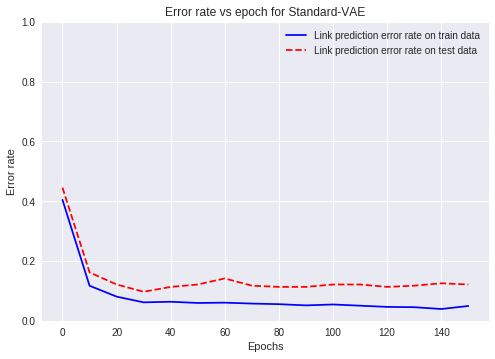

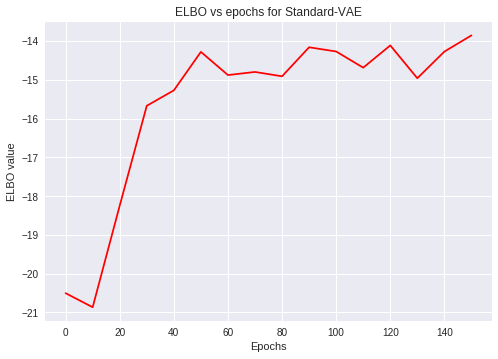

epoch:  0  - objective loss:  16.4568  - train accuracy:  0.5865  - test accuracy:  0.498
epoch:  10  - objective loss:  12.544  - train accuracy:  0.9333  - test accuracy:  0.8583
epoch:  20  - objective loss:  12.6788  - train accuracy:  0.9555  - test accuracy:  0.8907
epoch:  30  - objective loss:  11.8864  - train accuracy:  0.9606  - test accuracy:  0.8826
epoch:  40  - objective loss:  11.946  - train accuracy:  0.9687  - test accuracy:  0.8704
epoch:  50  - objective loss:  11.6487  - train accuracy:  0.9707  - test accuracy:  0.8583
epoch:  60  - objective loss:  11.8709  - train accuracy:  0.9757  - test accuracy:  0.8502
epoch:  70  - objective loss:  11.5797  - train accuracy:  0.9687  - test accuracy:  0.8664
epoch:  80  - objective loss:  11.6046  - train accuracy:  0.9707  - test accuracy:  0.8543
epoch:  90  - objective loss:  11.3073  - train accuracy:  0.9656  - test accuracy:  0.8583
epoch:  100  - objective loss:  11.5551  - train accuracy:  0.9656  - test accuracy:

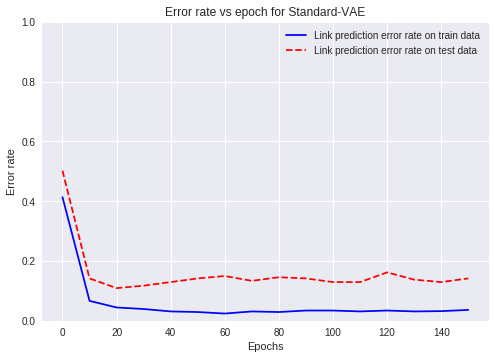

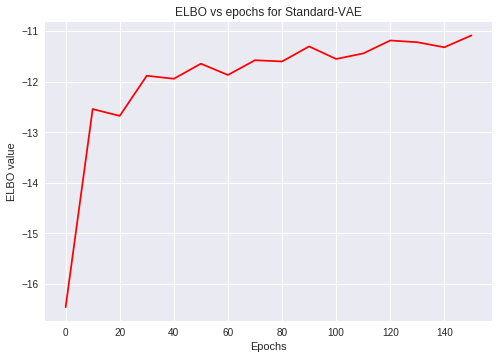

epoch:  0  - objective loss:  15.3617  - train accuracy:  0.5632  - test accuracy:  0.5425
epoch:  10  - objective loss:  11.6797  - train accuracy:  0.9444  - test accuracy:  0.8745
epoch:  20  - objective loss:  11.6381  - train accuracy:  0.9535  - test accuracy:  0.8745
epoch:  30  - objective loss:  11.8273  - train accuracy:  0.9525  - test accuracy:  0.8543
epoch:  40  - objective loss:  11.5137  - train accuracy:  0.9575  - test accuracy:  0.8543
epoch:  50  - objective loss:  11.5125  - train accuracy:  0.9545  - test accuracy:  0.8502
epoch:  60  - objective loss:  11.1688  - train accuracy:  0.9575  - test accuracy:  0.8543
epoch:  70  - objective loss:  11.1934  - train accuracy:  0.9555  - test accuracy:  0.8664
epoch:  80  - objective loss:  11.2586  - train accuracy:  0.9515  - test accuracy:  0.8583
epoch:  90  - objective loss:  11.4103  - train accuracy:  0.9596  - test accuracy:  0.8664
epoch:  100  - objective loss:  11.4527  - train accuracy:  0.9585  - test accura

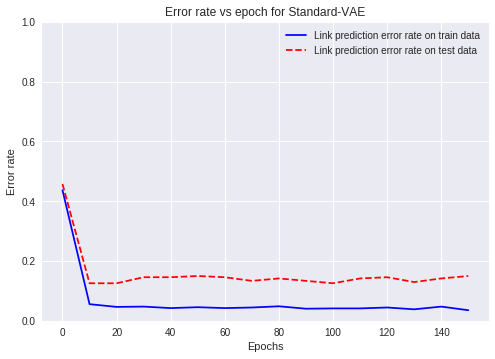

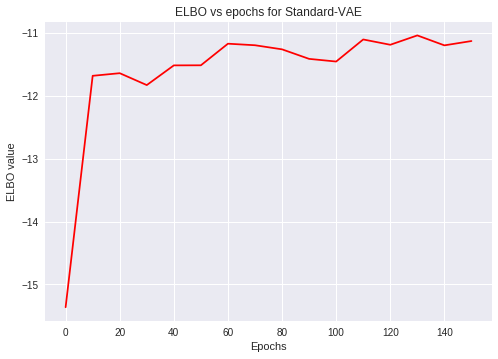

epoch:  0  - objective loss:  19.6515  - train accuracy:  0.5804  - test accuracy:  0.5749
epoch:  10  - objective loss:  14.5607  - train accuracy:  0.8665  - test accuracy:  0.8219
epoch:  20  - objective loss:  14.0461  - train accuracy:  0.9424  - test accuracy:  0.9028
epoch:  30  - objective loss:  14.1973  - train accuracy:  0.9464  - test accuracy:  0.9109
epoch:  40  - objective loss:  13.8456  - train accuracy:  0.9464  - test accuracy:  0.9109
epoch:  50  - objective loss:  14.1486  - train accuracy:  0.9565  - test accuracy:  0.915
epoch:  60  - objective loss:  13.879  - train accuracy:  0.9575  - test accuracy:  0.9231
epoch:  70  - objective loss:  13.6868  - train accuracy:  0.9515  - test accuracy:  0.9069
epoch:  80  - objective loss:  13.4843  - train accuracy:  0.9565  - test accuracy:  0.915
epoch:  90  - objective loss:  13.0141  - train accuracy:  0.9575  - test accuracy:  0.919
epoch:  100  - objective loss:  13.0775  - train accuracy:  0.9535  - test accuracy: 

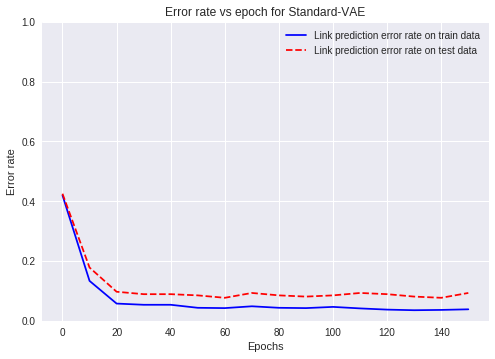

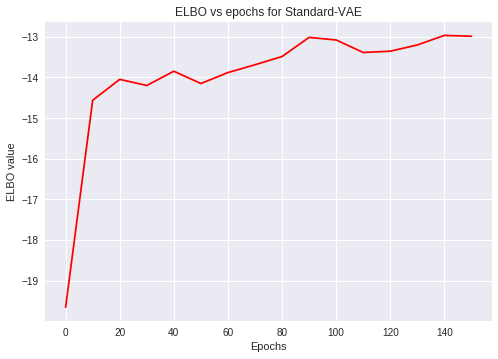

In [0]:
def train_on_synthetic_data(model, num_nodes, observed_dim, true_dim, fake_dim):
    sparsity = 0.25
    true_vectors, feature_vectors, train_adjacency_matrix, test_adjacency_matrix\
                = create_synthetic_data(num_nodes, sparsity, true_dim, observed_dim,
                                                                            fake_dim)
    # NOTE that there exists the 'interchangeability problem'
    # XR^TRX = X^TX
    # Y = XR^T
    model.fit(feature_vectors, train_adjacency_matrix, n_epochs=151, test_adjacency_matrix=test_adjacency_matrix)
    elbo_epochs = model.elbo_epochs()
    loss_epochs = model.loss_epochs()
    train_losses = model.tr_losses()
    test_losses = model.te_losses()
    ELBOs = model.elbos()
    

    plt.plot(loss_epochs, train_losses, '-', color='b', label='Link prediction error rate on train data')
    plt.plot(loss_epochs, test_losses, '--', color='r', label='Link prediction error rate on test data')
    plt.ylim((0, 1))
    plt.ylabel('Error rate')
    plt.xlabel('Epochs')
    plt.title("Error rate vs epoch for Standard-VAE")
    plt.legend()
    plt.show()
    
    plt.plot(elbo_epochs, ELBOs, '-', color='r', label='ELBO')
    plt.ylabel('ELBO value')
    plt.xlabel('Epochs')
    plt.title("ELBO vs epochs for Standard-VAE")
    plt.show()

    return model

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# for f in [0, 5, 7]:
#     num_nodes = 100
#     observed_dim = 15 - f
#     true_dim = 3
#     num_fake_dim = f

#     hidden_layer_sizes = [32]
#     naive_model = VariationalAutoencoder(n_dims_code=5, \
#                                    n_dims_data=observed_dim+num_fake_dim, \
#                                    hidden_layer_sizes=hidden_layer_sizes)

#     train_on_synthetic_data(naive_model, num_nodes, observed_dim, true_dim, num_fake_dim)
    
lambdas = [0.0, 1e-7, 1e-5, 1e-3]
  

for l in lambdas:
    for f in [7]:
        num_nodes = 100
        observed_dim = 15 - f
        true_dim = 3
        num_fake_dim = f

        hidden_layer_sizes = [32]
        vae_model = VariationalAutoencoder(n_dims_code=5, \
                                           n_dims_data=observed_dim+num_fake_dim, \
                                           hidden_layer_sizes=hidden_layer_sizes,
                                           reg_lambda=l)

        train_on_synthetic_data(vae_model, num_nodes, observed_dim, true_dim, num_fake_dim)


## 4.3 Training on KEGG datasets

In [0]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
lambdas = [0.0, 1e-7, 1e-5, 1e-3, 0.1]

for n_code in [20]:
    for l in lambdas:
        hidden_layer_sizes = [100]
        naive_model = VariationalAutoencoder(n_dims_code=n_code, \
                                       n_dims_data=feature_vectors_kegg.shape[1], \
                                       hidden_layer_sizes=hidden_layer_sizes,
                                       reg_lambda=l,)

        naive_model.fit(feature_vectors_kegg, train_adjacency_matrix_kegg, n_epochs=151, test_adjacency_matrix=test_adjacency_matrix_kegg)
        elbo_epochs = naive_model.elbo_epochs()
        loss_epochs = naive_model.loss_epochs()
        train_losses = naive_model.tr_losses()
        test_losses = naive_model.te_losses()
        ELBOs = naive_model.elbos()


        plt.plot(loss_epochs, train_losses, '-', color='b', label='Link prediction error rate on train data')
        plt.plot(loss_epochs, test_losses, '--', color='r', label='Link prediction error rate on test data')
        plt.ylim((0, 1))
        plt.ylabel('Error rate')
        plt.xlabel('Epochs')
        plt.title("Error rate vs epoch for Standard-VAE")
        plt.legend()
        plt.show()

        plt.plot(elbo_epochs, ELBOs, '-', color='r', label='ELBO')
        plt.ylabel('ELBO value')
        plt.xlabel('Epochs')
        plt.title("ELBO vs epochs for Standard-VAE")
        plt.show()



epoch:  0  - objective loss:  32.7824  - train accuracy:  0.6121  - test accuracy:  0.5957


KeyboardInterrupt: ignored

# 5. Do HS-VAE training

## 5.1 Training on synthetic data

Epoch 0.0 elbo -329.9786728636309 train-accuracy 0.4994944388270981 test-accuracy 0.4817813765182186
Epoch 10.0 elbo -184.68799354790306 train-accuracy 0.9332659251769464 test-accuracy 0.9109311740890689
Epoch 20.0 elbo -175.30921121960645 train-accuracy 0.9393326592517695 test-accuracy 0.9190283400809717
Epoch 30.0 elbo -174.47131171728358 train-accuracy 0.9514661274014156 test-accuracy 0.9311740890688259
Epoch 40.0 elbo -172.99241780551424 train-accuracy 0.9524772497472194 test-accuracy 0.951417004048583
Epoch 50.0 elbo -171.05242654635614 train-accuracy 0.9494438827098078 test-accuracy 0.9068825910931174
Epoch 60.0 elbo -171.539193412935 train-accuracy 0.9656218402426694 test-accuracy 0.9392712550607287
Epoch 70.0 elbo -171.98803476328365 train-accuracy 0.9625884732052579 test-accuracy 0.9352226720647774
Epoch 80.0 elbo -170.59420579555584 train-accuracy 0.9585439838220424 test-accuracy 0.9311740890688259
Epoch 90.0 elbo -170.99793987611207 train-accuracy 0.9575328614762386 test-acc

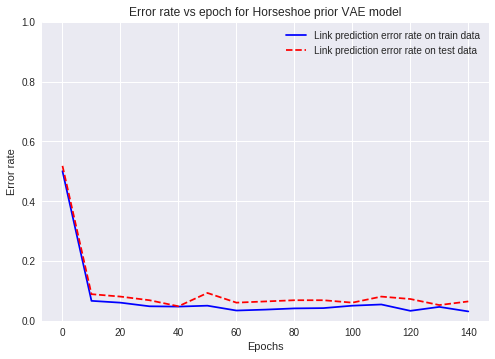

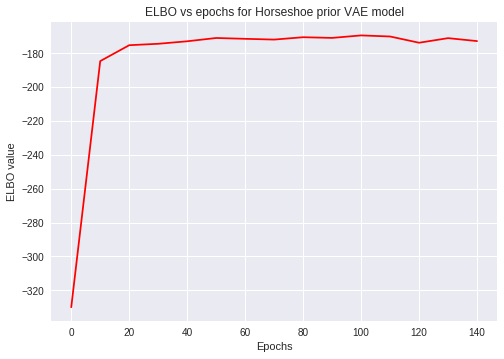

In [0]:
import autograd.numpy as np

for f in [7]:
    # Step 1. Create synthetic data
    num_nodes = 100
    observed_dim = 15 - f
    true_dim = 3
    num_fake_dim = f

    total_dim = observed_dim + num_fake_dim

    sparsity = 0.25
    true_vectors, feature_vectors, train_adjacency_matrix, test_adjacency_matrix\
                    = create_synthetic_data(num_nodes, sparsity, true_dim, observed_dim, num_fake_dim)


    # Step 2. Initialize horseshoe VAE

    hidden_layer_sizes = [32]

    hs_vae = HS_VAE(q_sigma=0.25,
                n_dims_code=5,
                n_dims_data=total_dim,
                hidden_layer_sizes=hidden_layer_sizes,
                classification=True,
                batch_size=20,
                lambda_b_global=1.0,
                warm_up=False,
                polyak=False)

    # Training
    hs_vae.fit(feature_vectors, train_adjacency_matrix, n_epochs=150, test_adjacency_matrix=test_adjacency_matrix)
    elbo_epochs = hs_vae.elbo_epochs()
    loss_epochs = hs_vae.loss_epochs()
    train_losses = hs_vae.tr_losses()
    test_losses = hs_vae.te_losses()
    ELBOs = hs_vae.elbos()


    plt.plot(loss_epochs, train_losses, '-', color='b', label='Link prediction error rate on train data')
    plt.plot(loss_epochs, test_losses, '--', color='r', label='Link prediction error rate on test data')
    plt.ylim((0, 1))
    plt.ylabel('Error rate')
    plt.xlabel('Epochs')
    plt.title("Error rate vs epoch for Horseshoe VAE")
    plt.legend()
    plt.show()

    plt.plot(elbo_epochs, ELBOs, '-', color='r', label='ELBO')
    plt.ylabel('ELBO value')
    plt.xlabel('Epochs')
    plt.title("ELBO vs epochs for Horseshoe VAE")
    plt.show()


## 5.2 Training on Kegg data

In [0]:
import autograd.numpy as np


hidden_layer_sizes = [100]
n_dims_data        = feature_vectors_kegg.shape[1]
num_negatives      = 64 # Number of negative samples

print("Number of nodes: ", feature_vectors_kegg.shape[0])
print("Dimension of feature vector: ", n_dims_data)

hs_vae = HS_VAE(q_sigma=0.2,
            n_dims_code=20,
            n_dims_data=n_dims_data,
            hidden_layer_sizes=hidden_layer_sizes,
            classification=True,
            batch_size=64,
            lambda_b_global=1.0,
            warm_up=False,
            polyak=False)

# Training
hs_vae.fit(feature_vectors_kegg, train_adjacency_matrix_kegg, n_epochs=150, test_adjacency_matrix=test_adjacency_matrix_kegg, num_negatives=num_negatives)


Number of nodes:  7847
Dimension of feature vector:  167
Epoch 0.0 elbo -10300.749446808637 train-accuracy 0.5199379804332634 test-accuracy 0.5087351502445842


# Plotting functions

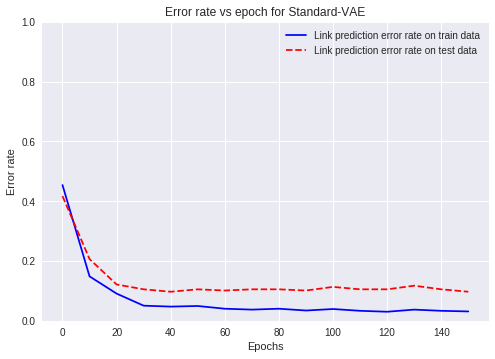

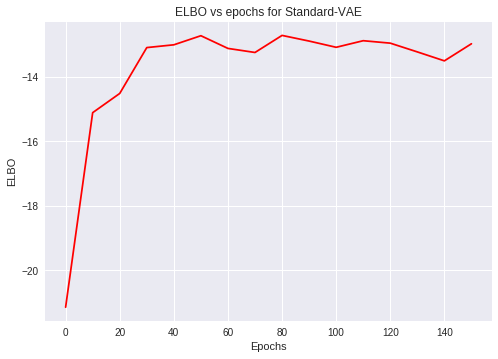

In [0]:
import matplotlib.pyplot as plt

inputstr = """epoch:  0  - objective loss:  21.1399  - train accuracy:  0.546  - test accuracy:  0.583
epoch:  10  - objective loss:  15.1101  - train accuracy:  0.8514  - test accuracy:  0.7935
epoch:  20  - objective loss:  14.5146  - train accuracy:  0.909  - test accuracy:  0.8785
epoch:  30  - objective loss:  13.0931  - train accuracy:  0.9494  - test accuracy:  0.8947
epoch:  40  - objective loss:  13.007  - train accuracy:  0.9525  - test accuracy:  0.9028
epoch:  50  - objective loss:  12.7254  - train accuracy:  0.9505  - test accuracy:  0.8947
epoch:  60  - objective loss:  13.1189  - train accuracy:  0.9596  - test accuracy:  0.8988
epoch:  70  - objective loss:  13.2447  - train accuracy:  0.9626  - test accuracy:  0.8947
epoch:  80  - objective loss:  12.7157  - train accuracy:  0.9596  - test accuracy:  0.8947
epoch:  90  - objective loss:  12.8911  - train accuracy:  0.9656  - test accuracy:  0.8988
epoch:  100  - objective loss:  13.0842  - train accuracy:  0.9606  - test accuracy:  0.8866
epoch:  110  - objective loss:  12.8801  - train accuracy:  0.9666  - test accuracy:  0.8947
epoch:  120  - objective loss:  12.9558  - train accuracy:  0.9697  - test accuracy:  0.8947
epoch:  130  - objective loss:  13.227  - train accuracy:  0.9626  - test accuracy:  0.8826
epoch:  140  - objective loss:  13.5042  - train accuracy:  0.9666  - test accuracy:  0.8947
epoch:  150  - objective loss:  12.9747  - train accuracy:  0.9687  - test accuracy:  0.9028
"""

import re


def extract_info_from_input(input):
    metrics_list = list()
    lines = input.split("\n")
    for line in lines:
        metrics = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        if not metrics:
            continue
        metrics_list.append(metrics)
    return metrics_list
        
metrics  = extract_info_from_input(inputstr)
# print(metrics)

epochs  =[float(info[0]) for info in metrics]

# NOTE: use one of these for elbo loss vs elbos
# elbos   =[float(info[1]) for info in metrics]
elbos   =[-float(info[1]) for info in metrics]

# NOTE: use one of the following for error vs accuracy


# train   =[info[2] for info in metrics]
# test    =[info[3] for info in metrics]

train   =[1. - float(info[2]) for info in metrics] 
test    =[1. - float(info[3]) for info in metrics]


train_label = 'Link prediction error rate on train data' # NOTE THE LABEL
test_label  = 'Link prediction error rate on test data'


model_name = "Standard-VAE" # <<<<< NOTE THE MODEL NAME

plt.plot(epochs, train, '-', color='b', label=train_label)
plt.plot(epochs, test, '--', color='r', label=test_label)
plt.ylim((0, 1))
plt.ylabel('Error rate')
plt.xlabel('Epochs')
plt.title("Error rate vs epoch for {}".format(model_name))
plt.legend()
plt.show()

plt.plot(epochs, elbos, '-', color='r', label='ELBO')
plt.ylabel('ELBO')
plt.xlabel('Epochs')
plt.title("ELBO vs epochs for {}".format(model_name))
plt.show()

# Testing on Tufts HPC cluster

Testing experiments results on KEGG dataset on tufts high performance computing 

##1. Which parameters to vary
-  Neural network structure
-  Dimension of latent code
-  sigma variance of the likelihood term

##2. Cross validation
- 10 fold cross validation

